# Credit Risk Analysis

### Importing libraries

In [67]:
import os
import math
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

### Loading data

In [166]:
filepath = os.path.join('..', 'resources', 'df_criado_final.csv')
df = pd.read_csv(filepath, delimiter=',')

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Escolaridade                 14615 non-null  float64
 1   Renda Mensal Informal        9768 non-null   float64
 2   Dependentes                  50390 non-null  object 
 3   Estado Civil                 50390 non-null  int64  
 4   Idade                        50390 non-null  int64  
 5   Conta Poupanca               50390 non-null  object 
 6   Conta Salario                50390 non-null  object 
 7   Quant Adiantamento Deposito  21843 non-null  float64
 8   Qtd Fonte Renda              12806 non-null  float64
 9   Cheque Sem Fundo             50390 non-null  object 
 10  Conta Conjunta               50390 non-null  object 
 11  Valor Conta Corrente         0 non-null      float64
 12  Valor Conta Poupanca         0 non-null      float64
 13  Valor Emprestimo

In [168]:
df.head()

,Escolaridade,Renda Mensal Informal,Dependentes,Estado Civil,Idade,Conta Poupanca,Conta Salario,Quant Adiantamento Deposito,Qtd Fonte Renda,Cheque Sem Fundo,...,Valor Emprestimo,Multa,Juros,Valor Emprestimo Atualizado,PAGO,Controle,ID,Genero,Data,Estado
0,NaN,NaN,S,2,36,S,N,NaN,NaN,N,...,8174.32,263.25,5844.98,14282.55,1,1,1328587.0,1,2020-01-01,57
1,1.0,1894.5078,N,2,39,S,N,2.0,1.0,S,...,41775.63,1607.29,7652.26,51035.18,1,1,1424254.0,1,2020-01-01,59
2,1.0,NaN,S,2,26,S,N,NaN,1.0,S,...,522940.27,24860.40,319315.62,867116.29,1,1,1438519.0,0,2020-01-01,56
3,NaN,NaN,N,8,23,N,N,NaN,NaN,N,...,1593.00,21472.36,2967.48,26032.84,1,1,1426138.0,1,2020-01-01,56
4,NaN,NaN,S,2,33,S,N,NaN,NaN,N,...,2078.97,19.44,46.35,2144.76,1,1,1474504.0,0,2020-01-01,59


### Removing features not related to credit risk

In [169]:
not_related_features = ['ID']
df = df.drop(columns=not_related_features, errors='ignore')

In [170]:
{ col: df[col].unique().size for col in df.columns }

{'Escolaridade': 4,
 'Renda Mensal Informal': 2342,
 'Dependentes': 2,
 'Estado Civil': 9,
 'Idade': 77,
 'Conta Poupanca': 2,
 'Conta Salario': 2,
 'Quant Adiantamento Deposito': 16,
 'Qtd Fonte Renda': 4,
 'Cheque Sem Fundo': 2,
 'Conta Conjunta': 2,
 'Valor Conta Corrente': 1,
 'Valor Conta Poupanca': 1,
 'Valor Emprestimo': 28577,
 'Multa': 33777,
 'Juros': 42139,
 'Valor Emprestimo Atualizado': 43191,
 'PAGO': 2,
 'Controle': 1,
 'Genero': 2,
 'Data': 1,
 'Estado': 4}

### Removing features with unique values

In [171]:
unique_value_features = [col for col in df.columns if df[col].unique().size == 1]
df = df.drop(columns=unique_value_features, errors='ignore')

### Removing columns with a proportion of missing values above a threshold

In [172]:
above_percentage_nan_features = [col for col in df.columns if df[col].isnull().mean() >= 0.8]
df = df.drop(columns=above_percentage_nan_features, errors='ignore')

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Escolaridade                 14615 non-null  float64
 1   Dependentes                  50390 non-null  object 
 2   Estado Civil                 50390 non-null  int64  
 3   Idade                        50390 non-null  int64  
 4   Conta Poupanca               50390 non-null  object 
 5   Conta Salario                50390 non-null  object 
 6   Quant Adiantamento Deposito  21843 non-null  float64
 7   Qtd Fonte Renda              12806 non-null  float64
 8   Cheque Sem Fundo             50390 non-null  object 
 9   Conta Conjunta               50390 non-null  object 
 10  Valor Emprestimo             50390 non-null  float64
 11  Multa                        50390 non-null  float64
 12  Juros                        50390 non-null  float64
 13  Valor Emprestimo

In [174]:
df['PAGO'].value_counts() / df.shape[0]

1    0.790891
0    0.209109
Name: PAGO, dtype: float64

In [175]:
cat = ['Escolaridade', 'Dependentes', 'Estado Civil', 'Conta Poupanca', 'Conta Salario', 'Qtd Fonte Renda', 'Cheque Sem Fundo', 'Conta Conjunta', 'Genero', 'Estado']
non_cat = ['Idade', 'Valor Emprestimo', 'Multa', 'Juros', 'Valor Emprestimo Atualizado']

df_cat = df[cat]
df_non_cat = df[non_cat]

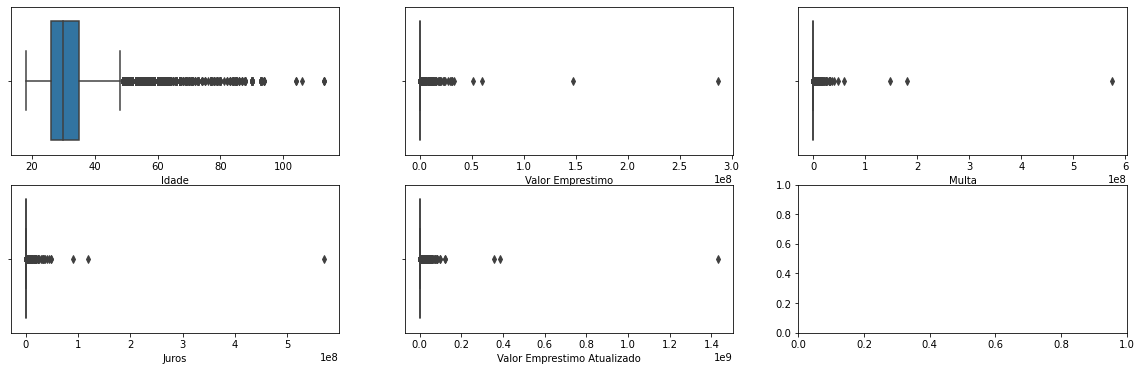

In [176]:
ncols = 3
nrows = 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,6))

for i, col in enumerate(df_non_cat.columns):
    c = i % ncols
    r = i // ncols
    sns.boxplot(df_non_cat[col], ax=ax[r][c])

In [177]:
z_score = np.abs(scipy.stats.zscore(df_non_cat))
z_score

array([[0.49917749, 0.02757733, 0.0210848 , 0.0216297 , 0.02237043],
       [0.84943887, 0.00642851, 0.02061219, 0.02096725, 0.01716336],
       [0.66836043, 0.29641871, 0.01243575, 0.09327286, 0.09845802],
       ...,
       [0.66836043, 0.03171964, 0.02110903, 0.02376233, 0.02413693],
       [0.66836043, 0.03171964, 0.02081223, 0.02376099, 0.02401682],
       [0.66836043, 0.03171964, 0.02101305, 0.02376714, 0.02410012]])

In [178]:
q1 = df_non_cat.quantile(0.25)
q3 = df_non_cat.quantile(0.75)
iqr = q3 - q1
iqr

Idade                              9.0000
Valor Emprestimo                5579.1750
Multa                           3467.4325
Juros                           5271.1550
Valor Emprestimo Atualizado    15072.3350
dtype: float64

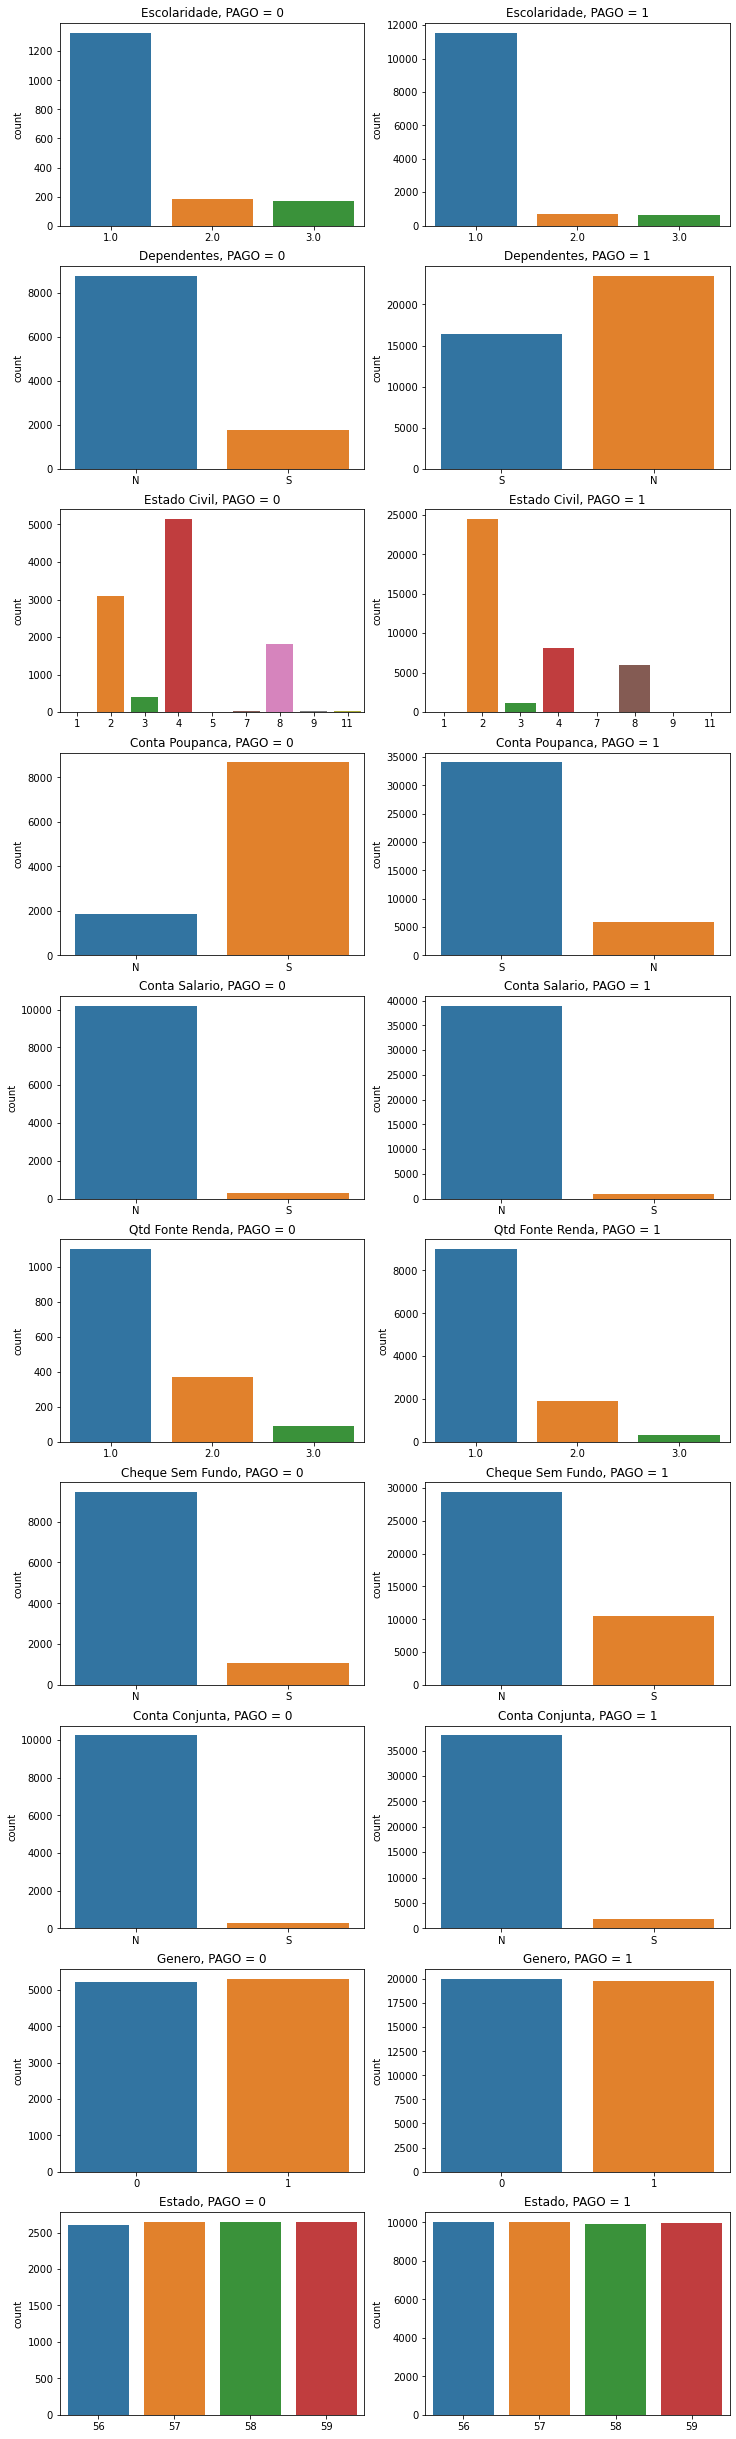

In [333]:
ncols = 2
nrows = 10
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 44))

for i, col in enumerate(df_cat.columns):
    c = (i * 2) % ncols
    r = (i * 2) // ncols
    for p in [0, 1]:
        ax[r][c+p].title.set_text('%s, PAGO = %s' % (col, p))
        sns.countplot(df[df['PAGO'] == p][col].values, x=col, ax=ax[r][c+p])

In [179]:
df.isnull().mean().sort_values(ascending=False)

Qtd Fonte Renda                0.745862
Escolaridade                   0.709962
Quant Adiantamento Deposito    0.566521
Dependentes                    0.000000
Estado Civil                   0.000000
Idade                          0.000000
Conta Poupanca                 0.000000
Conta Salario                  0.000000
Estado                         0.000000
Genero                         0.000000
Conta Conjunta                 0.000000
Valor Emprestimo               0.000000
Multa                          0.000000
Juros                          0.000000
Valor Emprestimo Atualizado    0.000000
PAGO                           0.000000
Cheque Sem Fundo               0.000000
dtype: float64

### Handling missing values

In [77]:
df = df.fillna(0)

### Splitting dataset

In [12]:
X = df.drop('PAGO', axis=1)
y = df['PAGO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### One-hot encoding categorical features

In [37]:
for col in df_cat.columns:
    one_hot_col = pd.get_dummies(df[col], prefix=col)
    df = df.drop(col, axis=1).join(one_hot_col)